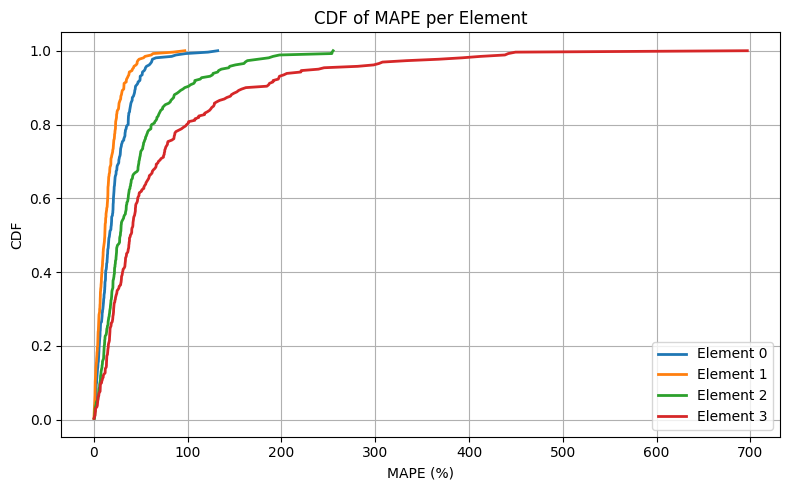

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt

# ----- Parse lines -----

num_elements = None
element_values = []
FILE = "a.txt"
# exp_lines = [
#     "smith_run_2025-05-21_17-51-36_thread-3196032430296.json MAPE per element: ['31.07%', '28.23%', '15.48%', '9.14%']",
#     "smith_run_2025-05-21_17-47-32_thread-3181576483152.json MAPE per element: ['12.27%', '25.00%', '42.25%', '11.32%']"
# ]
with open(FILE, "r") as file:
    for line in file:
        match = re.search(r"MAPE per element:\s*(\[[^\]]+\])", line)
        if match:
            percents_str = match.group(1)
            # Convert string list to actual list of floats (strip '%')
            values = [float(s.strip().replace('%', '').strip("'")) for s in percents_str.strip("[]").split(",")]
            if num_elements is None:
                num_elements = len(values)
                element_values = [[] for _ in range(num_elements)]
            for i, val in enumerate(values):
                element_values[i].append(val)

# ----- Plot CDFs -----

plt.figure(figsize=(8, 5))

for i, vals in enumerate(element_values):
    sorted_vals = np.sort(vals)
    cdf = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)
    plt.plot(sorted_vals, cdf, label=f'Element {i}', linewidth=2)

plt.xlabel("MAPE (%)")
plt.ylabel("CDF")
plt.title("CDF of MAPE per Element")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
#print the 90th percentile for each element
mau_len_95th_percentile = 0
latency_95th_percentile = 0
for i, vals in enumerate(element_values):
    percentile_90 = np.percentile(vals, 90)
    print(f"Element {i} 90th Percentile: {percentile_90:.2f}%")
for i, vals in enumerate(element_values):
    percentile_95 = np.percentile(vals, 95)
    if i == 0:
        mau_len_95th_percentile = percentile_95
    if i == 1:
        latency_95th_percentile = percentile_95
    print(f"Element {i} 95th Percentile: {percentile_95:.2f}%")


Element 0 90th Percentile: 44.17%
Element 1 90th Percentile: 31.88%
Element 2 90th Percentile: 97.29%
Element 3 90th Percentile: 164.28%
Element 0 95th Percentile: 54.59%
Element 1 95th Percentile: 41.08%
Element 2 95th Percentile: 136.25%
Element 3 95th Percentile: 239.78%


In [6]:
with open(FILE, "r") as file:
    for line in file:
        match = re.search(r"MAPE per element:\s*(\[[^\]]+\])", line)
        if match:
            percents_str = match.group(1)
            # Convert string list to actual list of floats (strip '%')
            values = [float(s.strip().replace('%', '').strip("'")) for s in percents_str.strip("[]").split(",")]
            # check if the values are exceeding 90th percentile
            for i, val in enumerate(values):
                if i == 0 and val > mau_len_95th_percentile:
                    print(f"Element {i} value {val:.2f}% exceeds mau_len 95th percentile {mau_len_95th_percentile:.2f}%, FILE: {line.strip()}")
                if i == 1 and val > latency_95th_percentile:
                    print(f"Element {i} value {val:.2f}% exceeds latency 95th percentile {latency_95th_percentile:.2f}%, FILE: {line.strip()}")



Element 0 value 66.14% exceeds mau_len 95th percentile 54.59%, FILE: smith_run_2025-06-05_02-48-21_thread-3271653483326.json MAPE per element: ['66.14%', '31.88%', '7.52%', '86.20%']
Element 0 value 56.03% exceeds mau_len 95th percentile 54.59%, FILE: smith_run_2025-06-05_02-46-31_thread-3271627439999.json MAPE per element: ['56.03%', '46.06%', '186.46%', '184.48%']
Element 1 value 46.06% exceeds latency 95th percentile 41.08%, FILE: smith_run_2025-06-05_02-46-31_thread-3271627439999.json MAPE per element: ['56.03%', '46.06%', '186.46%', '184.48%']
Element 1 value 54.46% exceeds latency 95th percentile 41.08%, FILE: smith_run_2025-06-05_02-49-21_thread-3271635682546.json MAPE per element: ['14.64%', '54.46%', '48.69%', '63.30%']
Element 0 value 82.95% exceeds mau_len 95th percentile 54.59%, FILE: smith_run_2025-06-05_02-54-20_thread-3290878936353.json MAPE per element: ['82.95%', '8.52%', '24.14%', '145.63%']
Element 1 value 52.88% exceeds latency 95th percentile 41.08%, FILE: smith_ru

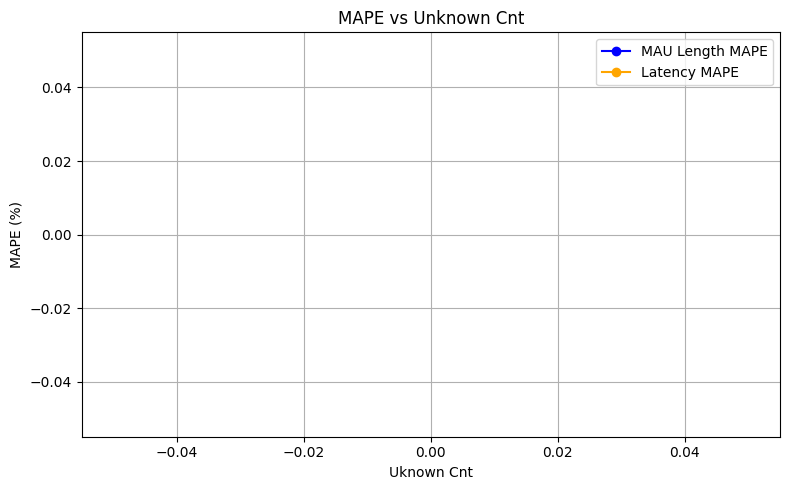

In [5]:
# read in format smith_run_2025-05-21_17-42-28_thread-3159341633266.json: ratio: 0.41 unknown_cnt: 10 total: 17

tbl_cnt_file = "table_num_cnt.txt"
cnts = {}
with open(tbl_cnt_file, "r") as file:
    # ontain filename and values
    for line in file:
        match = re.search(r"([\w-]+\.json):\s*ratio:\s*([\d.]+)\s*unknown_cnt:\s*(\d+)\s*total:\s*(\d+)", line)
        if match:
            filename = match.group(1)
            ratio = float(match.group(2))
            unknown_cnt = int(match.group(3))
            total = int(match.group(4))
            cnts[filename] = [ratio, unknown_cnt, total]
# plot the mape as cnt increasing
mapes = {}
with open(FILE, "r") as file:
    for line in file:
        match = re.search(r"([\w-]+\.json) MAPE per element:\s*(\[[^\]]+\])", line)
        if match:
            filename = match.group(1)
            percents_str = match.group(2)
            # Convert string list to actual list of floats (strip '%')
            values = [float(s.strip().replace('%', '').strip("'")) for s in percents_str.strip("[]").split(",")]
            mapes[filename] = values

# Prepare data for plotting
totals = []
for filename, (ratio, unknown_cnt, total) in cnts.items():
    if filename in mapes:
        mape_values = mapes[filename]
        totals.append((unknown_cnt, mape_values[0], mape_values[1]))  # (total, mau_len_mape, latency_mape)
# Sort totals by the first element (total)
totals.sort(key=lambda x: x[0])
# Extract sorted totals, mau_len_mape, and latency_mape
sorted_totals = [t[0] for t in totals]
mau_len_mapes = [t[1] for t in totals]
latency_mapes = [t[2] for t in totals]
# Plot the MAPE values against the total counts
plt.figure(figsize=(8, 5))
plt.plot(sorted_totals, mau_len_mapes, label='MAU Length MAPE', marker='o', color='blue')
plt.plot(sorted_totals, latency_mapes, label='Latency MAPE', marker='o', color='orange')
plt.xlabel("Uknown Cnt")
plt.ylabel("MAPE (%)")
plt.title("MAPE vs Unknown Cnt")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


                
